# Jobs Explorer

In [1]:
from typing import List, MutableSet, Tuple, Dict
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
%matplotlib inline

# Load data

In [3]:
import mysql.connector

def get_raw_data(host: str, user: str, password: str, db: str, table: str) -> pd.DataFrame:
    connection = mysql.connector.connect(user=user, password=password, host=host, database=db)
    cursor = connection.cursor(dictionary=True)
    select_statement = f'SELECT * FROM {table};'
    cursor.execute(select_statement)
    
    data = pd.DataFrame.from_records(cursor, index='id').convert_dtypes()

    cursor.close()
    connection.close()
    
    data['date_published'] = pd.to_datetime(data['date_published'])
    
    for categorical_column in ('source', 'salary_currency', 'schedule_type', 'employment_type', 'region', 'experience_range_hh'):
        data[categorical_column] = data[categorical_column].astype('category', copy=False)
        
    for boolean_column in ('salary_gross_indicator', 'cover_letter_required', 'test_required_hh', 'test_included_hh'):
        data[boolean_column] = data[boolean_column].astype('boolean', copy=False)

    return data

In [4]:
raw_data = get_raw_data('127.0.0.1', '', '', 'jobs', 'vacancies')

In [5]:
raw_data.shape

(20029, 18)

# Filter data

In [6]:
raw_data.drop_duplicates(subset=['id_source', 'source'], keep='last', inplace=True)

In [7]:
raw_data.shape

(8955, 18)

In [8]:
excluded_names = (
    'Продавец',
    'Старший продавец',
    'Кассир',
    'Администратор-кассир',
    'Старший кассир',
    'Оператор-кассир',
    'Офис-менеджер',
    'Специалист пункта выдачи заказов',
    'Оператор клиентского',
    'Старший оператор клиентского',
    'Товаровед',
    'Специалист по предоставлению услуг',
    'Главный специалист отдела администрирования',
    'грузчик',
    'договорного отдела',
    'Делопроизводитель',
    'Специалист по работе с клиентами',
    'Аналитик продаж',
    'Руководитель отдела аналитики',
    'Водитель-инкассатор',
    'Помощник руководителя',
    'Оператор call-центра',
    'Преподаватель',
    'HR',
    'управляющий магазином',
    'ломбардного отделения',
    'правового отдела',
    'недвижимости',
    'отдела продаж',
    'отдела статистики',
    'статистики',
    'статистического',
    'аналитик баз',
    'Аналитического управления'
)

hh_employer_blacklist = (
    '4445173',
)

raw_data = raw_data.loc[
    ~raw_data['name'].str.contains('|'.join(excluded_names))
]
raw_data = raw_data.loc[
    ~raw_data['employer_id_hh'].isin(hh_employer_blacklist)
]

In [9]:
raw_data.shape

(7222, 18)

# Build features

### Split 'Description'
Extract sections from description:
- Duties
- Requirements
- Conditions
- About Us
- Misc

In [10]:
pattern_duties = re.compile(r'\b(обязанности\b|задачи|функционал|предстоит|(нужно)? делать:|доверим|зона ответственности|(в|т)ы буде(те|шь)|job (description|profile)|responsibilities|functions|assignments|you will be responsible for|role( will)? involv(e|es)|tasks)\s?:?', flags=re.IGNORECASE)
pattern_reqs = re.compile(r'\b(требования?\b|(жд|ожида)(ния|(е|ё)м)|пожелания\b|у (тебя|вас) есть|от вас|у вас были|на(м|с) (действительно)? важно|чтобы стать кандидатом|идеальный кандидат|вам подойд(е|ё)т|необходимые компетенции|рады сотрудничать, если|для этого необходимо|если вы|требуется|requirements|qualifications|expertise|experience|candidate\W?s profile|if you have|competencies)\s?:?', flags=re.IGNORECASE)
pattern_conditions = re.compile(r'\b(предлагае(м|т)\b|условия\b|чего ожидать|(предоставим|гарантируем|обеспечим)|плю(с|шки)|предлож(ить|ение)|вы получите возможность|работа в нашей|we (offer|propose)|condition|compensation|terms)\s?:?', flags=re.IGNORECASE)
pattern_about = re.compile(r'\b(о нас|о компании|почему \w? на\w*|работа в .* это|кто мы|about us|corporate citizenship)\s?:?', flags=re.IGNORECASE)

In [11]:
def split_description(description: str) -> Dict[str, str]:
    description_lines = description.split('\n')
    last_line_idx = len(description_lines) - 1
    
    # Sections are searched bottom up from the last line.
    # 'Misc' section contains everything from starting line to uppermost section found.
    indices_start: Dict[str, int] = {
        'description_duties': last_line_idx,
        'description_requirements': last_line_idx,
        'description_conditions': last_line_idx,
        'description_about': last_line_idx,
        'description_misc': 0
    }
    
    patterns: Dict[str, object] = {
        'description_duties': pattern_duties,
        'description_requirements': pattern_reqs,
        'description_conditions': pattern_conditions,
        'description_about': pattern_about,
    }
        
    # Search for section headers
    for section_name, pattern in patterns.items():        
        for line_idx in range(len(description_lines)):
            if pattern.search(description_lines[line_idx]):
                indices_start[section_name] = line_idx
                break
    
    sections: Dict[str, str] = {
        'description_duties': None,
        'description_requirements': None,
        'description_conditions': None,
        'description_about': None,
        'description_misc': None
    }
    
    # Traverse description lines bottom-up
    idx_end = last_line_idx
    def by_value(item): return item[1]
    for section_name, idx_start in sorted(indices_start.items(), key=by_value, reverse=True):
        sections[section_name] = '\n'.join(description_lines[idx_start+1:idx_end]) # Section header is dropped 
        idx_end = idx_start
    
    return sections

In [12]:
raw_data = raw_data.join(raw_data['description'].map(split_description).apply(pd.Series), on='id', how='outer')

### Build refined description

In [13]:
descriptions_raw = (raw_data['description_duties'] + raw_data['description_requirements']).values

### Define pre-processing rules

In [14]:
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

class DescriptionPreprocessor:
    def __init__(self):
        self.pattern_russian_chars = re.compile(r'[а-яА-Я]')
        
        self.lemmatizer_eng = WordNetLemmatizer()
        self.lemmatizer_rus = Mystem()
    
    def _get_wordnet_pos(self, word: str):
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {'J': wordnet.ADJ,
                    'N': wordnet.NOUN,
                    'V': wordnet.VERB,
                    'R': wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
    def __call__(self, doc: str) -> str:        
        if self.pattern_russian_chars.search(doc):
            return ''.join(self.lemmatizer_rus.lemmatize(doc.lower())[:-1])
        else:
            return ' '.join([self.lemmatizer_eng.lemmatize(word, self._get_wordnet_pos(word)) for word in word_tokenize(doc.lower())])

### Convert to n-grams

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english') + stopwords.words('russian')

In [16]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    min_df=0.001,
    max_df=0.5,
    binary=False,
    preprocessor=DescriptionPreprocessor(),
    token_pattern=r'(?u)\b\S+\b',
    lowercase=True,
    stop_words=stop_words,
    dtype=np.float32,
)

In [ ]:
%time descriptions_tfidf = vectorizer.fit_transform(descriptions_raw)

In [18]:
descriptions_tfidf.shape

(7222, 3996)

In [19]:
print('Share of remaining tokens: {0}%'.format(round(descriptions_tfidf.shape[1] / (len(vectorizer.stop_words_) + descriptions_tfidf.shape[1]) * 100, 0)))

Share of remaining tokens: 22.0%


In [20]:
for feature_idx in np.argsort(vectorizer.idf_)[:10]:
    print(vectorizer.get_feature_names()[feature_idx])

контроль
подготовка
1с
бухгалтерский
отчетность
ведение
документ
excel
компания
формирование


# Train models

## Clustering

### Agglomerative clustering

In [21]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

In [22]:
%time distances_squareform = pairwise_distances(descriptions_tfidf.toarray(), metric='cosine', force_all_finite=True, n_jobs=-1)

CPU times: user 9.71 s, sys: 635 ms, total: 10.3 s
Wall time: 2.85 s


In [23]:
np.fill_diagonal(distances_squareform, 0)
descriptions_distances = squareform(X=distances_squareform, checks=False)

In [24]:
from scipy.cluster.hierarchy import ward, fcluster

In [25]:
%time clustering_model = ward(descriptions_distances)

CPU times: user 1.61 s, sys: 162 ms, total: 1.77 s
Wall time: 2.15 s


### Choosing target number of clusters

In [26]:
from sklearn.metrics import silhouette_score

In [27]:
possible_clusters = list(range(2,20,1))

scores = []
for num_clusters in possible_clusters:
    cluster_labels = fcluster(clustering_model, t=num_clusters, criterion='maxclust')
    score = silhouette_score(distances_squareform, cluster_labels, metric='precomputed', random_state=42)
    scores.append(score)

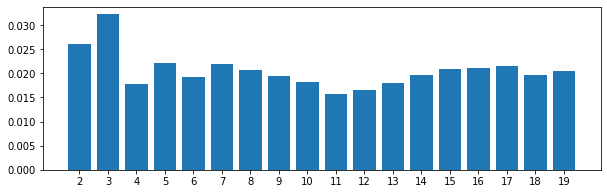

In [28]:
plt.figure(figsize=(10, 3))
plt.bar(possible_clusters, scores)
plt.xticks(possible_clusters)
plt.show()

In [29]:
target_num_clusters=10

cluster_ids = fcluster(clustering_model, t=target_num_clusters, criterion='maxclust')

### Cluster contents

In [30]:
for cluster, count in zip(*np.unique(cluster_ids, return_counts=True)):
    print(f'{cluster:2}: {count:4} jobs')

 1:  157 jobs
 2: 2008 jobs
 3:  285 jobs
 4:  776 jobs
 5:  262 jobs
 6:  207 jobs
 7: 1293 jobs
 8: 1951 jobs
 9:  121 jobs
10:  162 jobs


In [40]:
target_cluster_id = 10

raw_data.loc[cluster_ids == target_cluster_id, 'name'].value_counts()[:7]

Внутренний аудитор                        15
Аудитор                                    7
Ведущий внутренний аудитор                 4
Ведущий аудитор                            4
Главный аудитор                            4
Руководитель службы внутреннего аудита     3
Начальник отдела внутреннего аудита        3
Name: name, dtype: Int64

In [ ]:
for feature_idx in np.argsort(descriptions_tfidf[cluster_ids == target_cluster_id].sum(axis=0).tolist()[0])[-10:]:
    print(vectorizer.get_feature_names()[feature_idx])

In [41]:
cluster_mapping = {
    1: 'Экономисты и финансисты', 
    2: 'Бухгалтеры',
    3: 'Бухгалтеры',
    4: 'Бухгалтеры',
    5: 'Вакансии на английском',
    6: 'Экономисты и финансисты',
    7: 'Экономисты и финансисты',
    8: 'Экономисты и финансисты',
    9: 'Специалисты по МСФО и аудиторы',
    10: 'Специалисты по МСФО и аудиторы',
}

raw_data["cluster"] = [cluster_mapping[cluster_id] for cluster_id in cluster_ids]
raw_data["cluster"] = raw_data["cluster"].astype('category', copy=False)

# Visualize

## Dendrogram

In [42]:
from scipy.cluster.hierarchy import dendrogram

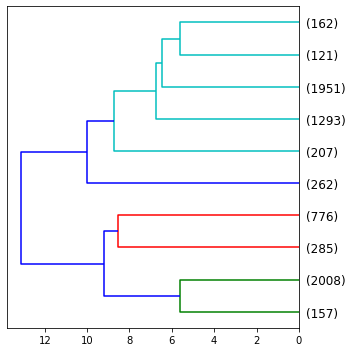

In [43]:
plt.figure(figsize=(5, 5))

ax = dendrogram(
    clustering_model,
    orientation='left',
    truncate_mode='lastp',
    p=target_num_clusters,
)

plt.tight_layout()
plt.show()
#plt.savefig('ward_clusters.png', dpi=200)

In [758]:
# Set picture size for Instagram story compatibility
current_figsize = (10.80, 6.08)
current_dpi = 100

current_marker = 'o'

alpha_level = 0.75

current_colormap = 'jet'
cluster_colors = {
    'Вакансии на английском': 0.87,
    'Бухгалтеры': 0.30,
    'Экономисты и финансисты': 0.48,
    'Специалисты по МСФО и аудиторы': 0.77,
}



def scatter(data, legend=True, annotate=False, save_file=False):
    three_d = (len(data[0]) == 3)
    
    # figure settings    
    figure = plt.figure(figsize=current_figsize, dpi=current_dpi)
    ax = figure.add_subplot(111, projection='3d') if three_d else figure.add_subplot(111)
    
    # coloring
    cmap = cm.get_cmap(current_colormap)
    
    # plotting
    for cluster_id, cluster_name in enumerate(cluster_annotation_coords):
        row_filter = (raw_data["cluster"] == cluster_name)
        
        if three_d:
            ax.plot(
                data[row_filter, 0],
                data[row_filter, 1],
                data[row_filter, 2],
                current_marker,
                color=cmap(cluster_colors[cluster_name]),
                label=cluster_name,
                alpha=alpha_level,
                mec='white',
            )
        else:
            ax.plot(
                data[row_filter, 0],
                data[row_filter, 1],
                current_marker,
                color=cmap(cluster_colors[cluster_name]),
                label=cluster_name,
                alpha=alpha_level,
                mec='white',
            )
        
        if annotate:
            # annotations
            ax.annotate(cluster_name.replace(' и','\nи').replace(' на','\nна'),
                xy = cluster_boundary_coords[cluster_name],  xycoords='data',
                xytext = cluster_annotation_coords[cluster_name], textcoords='data',
                ha='center', va='top',
                fontfamily='monospace',
                fontweight='medium',
                fontsize='xx-large',
                color='black',
                backgroundcolor='white',
                arrowprops = dict(
                    arrowstyle='-',
                    color='dimgray',
                    connectionstyle='arc3,rad=-0.3',
                    shrinkB = 10,
               ),
            )
            
    if legend:
        # legend
        ax.legend()
    
    # plotting settings
    ax.grid(False)
    plt.axis(False)
    plt.tight_layout()

    if save_file:
        plt.savefig('scatter.png')
    plt.show()

## 2D Scatter

### SVD

In [45]:
from sklearn.decomposition import TruncatedSVD

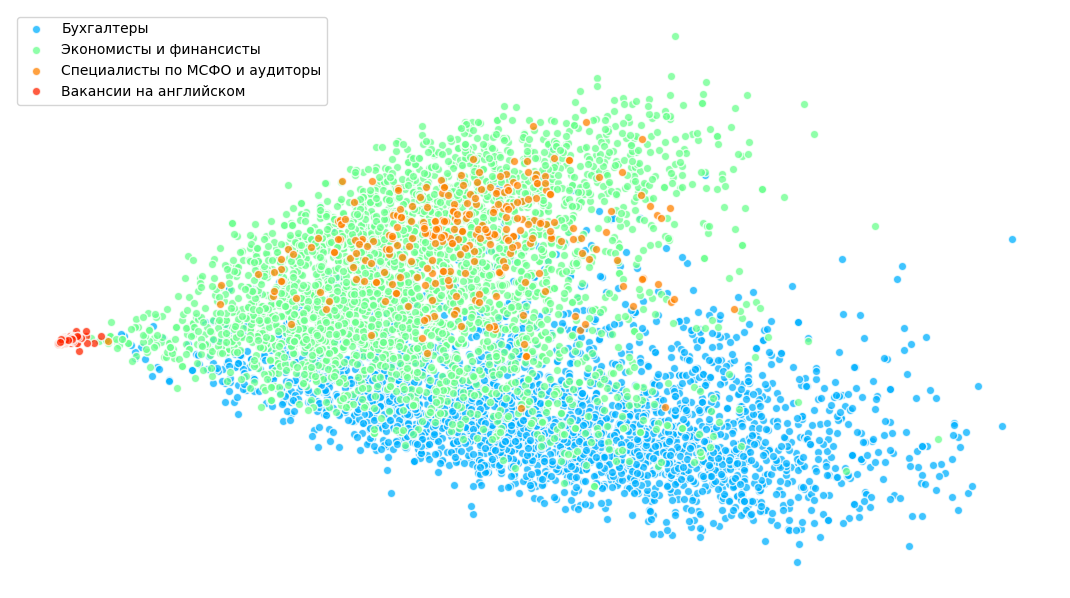

In [799]:
descriptions_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(descriptions_tfidf)
scatter(descriptions_svd)

### PCA

In [50]:
from sklearn.decomposition import PCA

In [51]:
descriptions_pca = PCA(n_components=2, random_state=42).fit_transform(descriptions_tfidf.toarray())

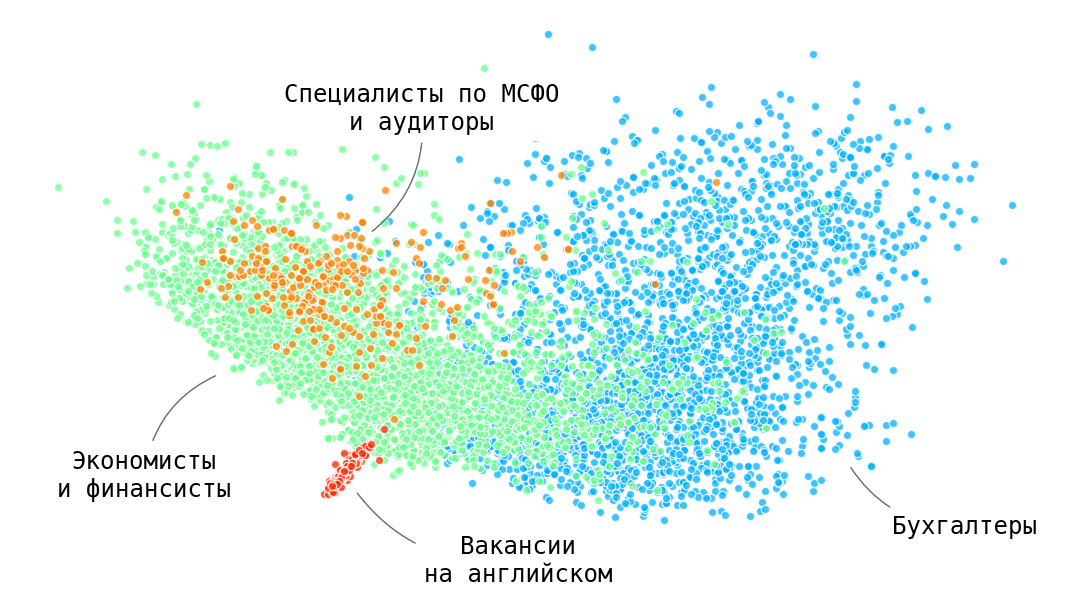

In [798]:
cluster_annotation_coords = {
    'Бухгалтеры':                     ( 0.40, -0.25),
    'Экономисты и финансисты':        (-0.28, -0.15),
    'Специалисты по МСФО и аудиторы': (-0.05,  0.41),
    'Вакансии на английском':         ( 0.03, -0.28),
}
cluster_boundary_coords = {
    'Бухгалтеры':                     ( 0.30, -0.16),
    'Экономисты и финансисты':        (-0.21, -0.03),
    'Специалисты по МСФО и аудиторы': (-0.10,  0.17),
    'Вакансии на английском':         (-0.11, -0.20),
}
scatter(descriptions_pca, annotate=True, legend=False, save_file=True)

# Export data for TensorFlow Embedding Projector

In [800]:
raw_data["url"] = 'https://hh.ru/vacancy/' + raw_data["id_source"]

In [801]:
def write_tf_projector_files(embeddings):
    vectors_file_path = 'vectors.tsv'
    metadata_file_path = 'metadata.tsv'

    vectors_file = open(vectors_file_path, 'w', encoding='utf-8')
    metadata_file = open(metadata_file_path, 'w', encoding='utf-8')

    # write feature labels to metadata
    metadata_features = ['cluster', 'name', 'employer_name', 'url']
    metadata_file.write('\t'.join(metadata_features) + "\n")

    for i in range(embeddings.shape[0]):
        metadata_file.write('\t'.join([str(metadata_item) for metadata_item in raw_data.loc[raw_data.index[i], metadata_features]]) + "\n")
        vectors_file.write('\t'.join([str(feature_value) for feature_value in embeddings[i].toarray()[0]]) + "\n")

    vectors_file.close()
    metadata_file.close()

In [802]:
%time write_tf_projector_files(descriptions_tfidf)

CPU times: user 20.2 s, sys: 739 ms, total: 21 s
Wall time: 24.1 s
